# Data Exploration

| Date | User | Change Type | Remarks |  
| ---- | ---- | ----------- | ------- |
| 24/07/2025   | Martin | Create  | Started project data exploration on math misunderstandings | 

# Content

* [Simple EDA](#simple-eda)
* [How different are questions and answers semantically](#how-different-are-questions-and-answers-semantically)
* [Modeling Ideas](#modeling-ideas)

# Simple EDA

In [1]:
%load_ext watermark

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, Math

In [3]:
# Loading data
train = pd.read_csv('data/raw/train.csv')
test = pd.read_csv('data/raw/test.csv')

print(f"Train: {train.shape} | Test: {test.shape}")

Train: (36696, 7) | Test: (3, 5)


In [4]:
# train.sample(n=5).head()
train.head()

,row_id,QuestionId,QuestionText,MC_Answer,StudentExplanation,Category,Misconception
0,0,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),0ne third is equal to tree nineth,True_Correct,NaN
1,1,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 / 3 because 6 over 9 is 2 thirds and 1 third...,True_Correct,NaN
2,2,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),"1 3rd is half of 3 6th, so it is simplee to un...",True_Neither,NaN
3,3,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 goes into everything and 3 goes into nine,True_Neither,NaN
4,4,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 out of every 3 isn't coloured,True_Correct,NaN


In [8]:
train[~train['Misconception'].isna()].head()

,row_id,QuestionId,QuestionText,MC_Answer,StudentExplanation,Category,Misconception
107,107,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),3 out of 9 parts aren't shaded.,True_Misconception,Incomplete
120,120,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),3 out of 9 triangles are not shaded.,True_Misconception,Incomplete
123,123,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),3 out of nine triangles are not shaded,True_Misconception,Incomplete
265,265,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),3/9 of the shape isn't shaded,True_Misconception,Incomplete
518,518,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),Because there are 6 triangles and 3 are white....,True_Misconception,WNB


In [5]:
train['is_correct'] = train['Category'].str.split("_").str[0]
train['is_correct'] = train['is_correct'].map(lambda x: 1 if x == "True" else 0)
train['is_misconception'] = train['Category'].str.split("_").str[1]
train['Misconception'] = train['Misconception'].fillna('NA')
train = train.drop(['row_id'], axis=1)

In [6]:
train.head()

,QuestionId,QuestionText,MC_Answer,StudentExplanation,Category,Misconception,is_correct,is_misconception
0,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),0ne third is equal to tree nineth,True_Correct,NA,1,Correct
1,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 / 3 because 6 over 9 is 2 thirds and 1 third...,True_Correct,NA,1,Correct
2,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),"1 3rd is half of 3 6th, so it is simplee to un...",True_Neither,NA,1,Neither
3,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 goes into everything and 3 goes into nine,True_Neither,NA,1,Neither
4,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 out of every 3 isn't coloured,True_Correct,NA,1,Correct


## Breakdown of all questions

- Most questions that were answered correctly had the right explanation, while those that were incorrect are closer to neight and wrong explanation
	- What do the outliers represent?

Text(0.5, 1.0, 'Number of responses that are correct')

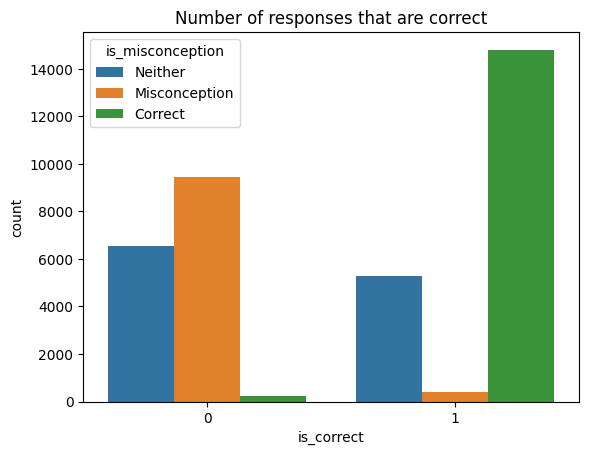

In [27]:
sns.countplot(train, x='is_correct', hue='is_misconception')
plt.title('Number of responses that are correct')

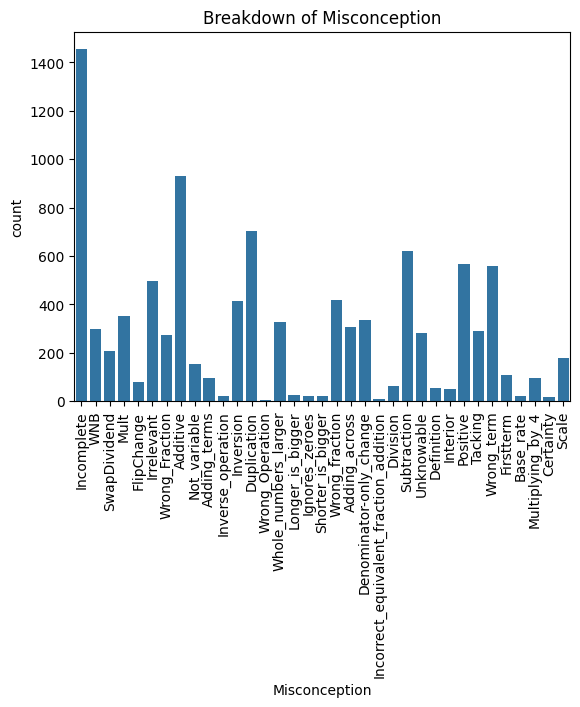

In [32]:
sns.countplot(train[train['Misconception'] != 'NA'], x='Misconception')
plt.title("Breakdown of Misconception")
plt.xticks(rotation=90)
plt.show()

## Breakdown of specific questions

<u>Insights</u>

- Most questions are relatively balanced between their correct and incorrect responses (except 31774 and 31777)
- Majority of the questions have a majority mistake occurring across them
	- e.g 31772 - Incomplete, 31778 - Additive

In [44]:
def gb_count_plot(field: str):
	d = train.groupby(['QuestionId', field]).count()['QuestionText'].reset_index()
	sns.barplot(data=d, x='QuestionId', y='QuestionText', hue=field)
	plt.title(f"Number of reponses subset by {field}")
	plt.xticks(rotation=90)

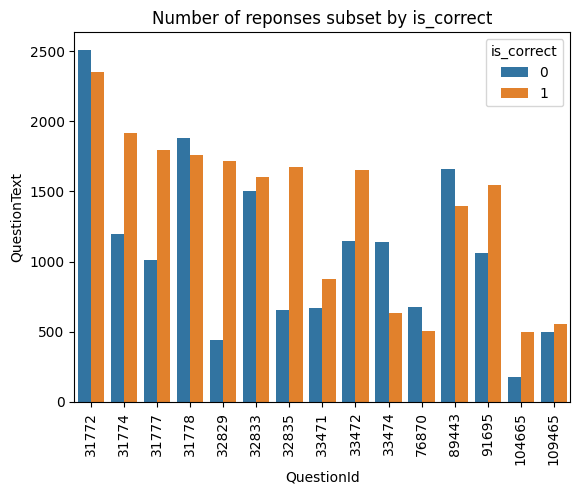

In [45]:
gb_count_plot('is_correct')

Text(0.5, 1.0, 'Misconception type grouped by QuestionId')

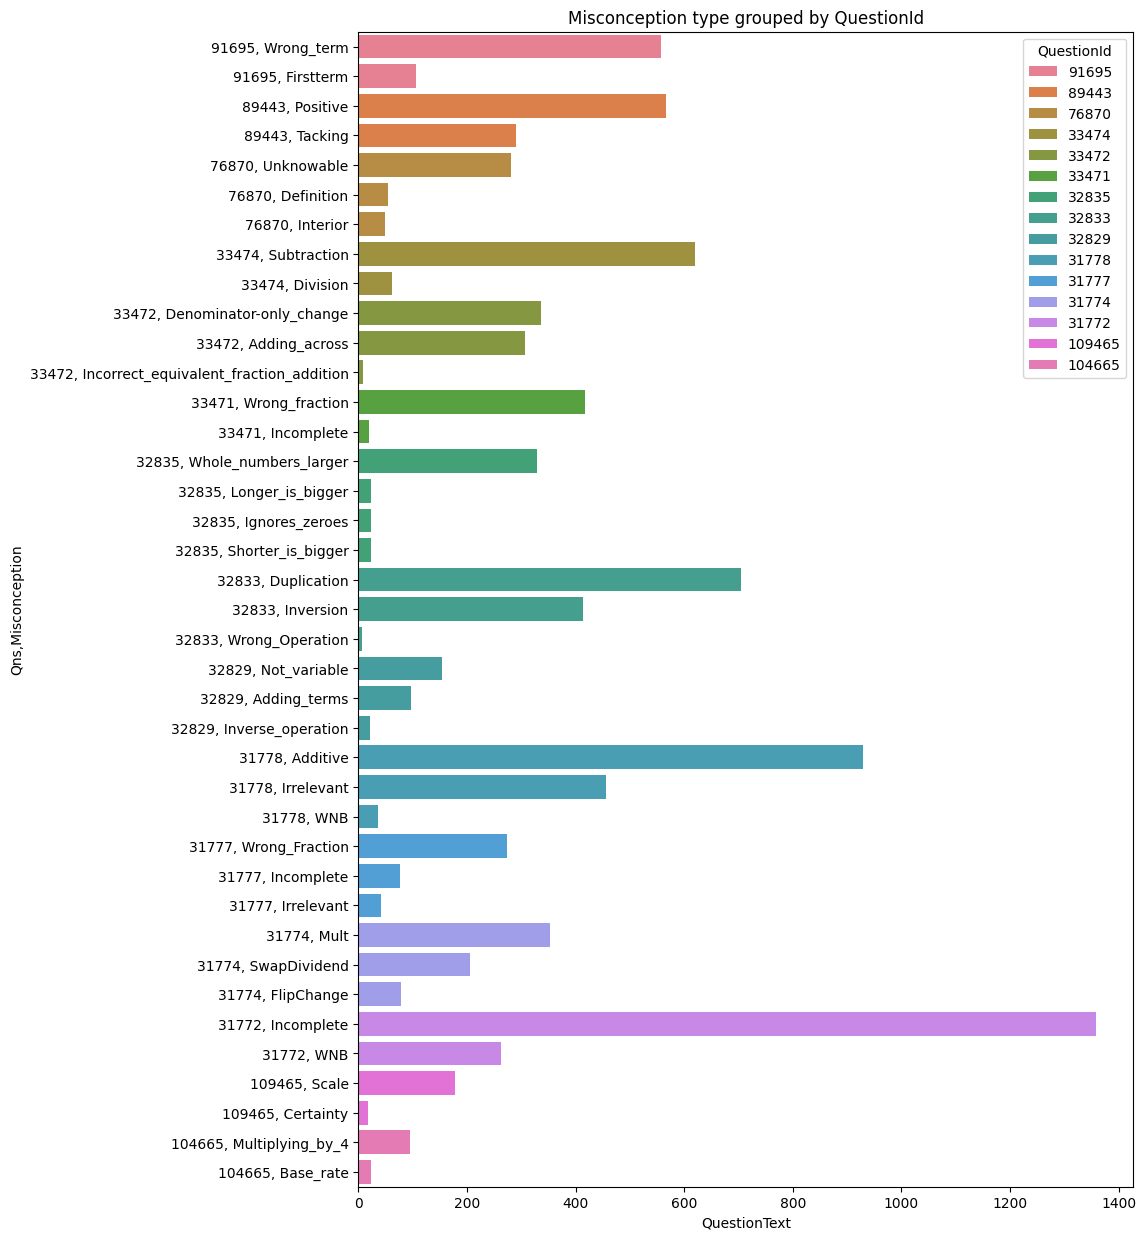

In [81]:
d = train.groupby(['QuestionId', 'Misconception']).count()['QuestionText'].reset_index()
d['Qns,Misconception'] = d['QuestionId'].astype(str) + ", " + d["Misconception"]
d['QuestionId'] = d['QuestionId'].astype(str)
d = d[d['Misconception'] != 'NA']
d = d.sort_values(['QuestionId', 'QuestionText'], ascending=False)
fig, ax = plt.subplots(figsize=(10, 15))
sns.barplot(data=d, y='Qns,Misconception', x='QuestionText', orient='h', hue='QuestionId', ax=ax)
ax.set_title("Misconception type grouped by QuestionId")

## Summary

In [114]:
correct = sum(train['is_correct'])
incorrect = train.shape[0] - correct
misconceptions = len(set(train['Misconception']))
entry = train.iloc[0]

In [115]:
print("=" * 30)
print("Summary of Data")
print("=" * 30)

print(f"Total Size: {train.shape}")
print(f"Number of Correct vs. Incorrect: {(correct, incorrect)}")
print(f"Number of Unique Misconceptions: {misconceptions}")

Summary of Data
Total Size: (36696, 8)
Number of Correct vs. Incorrect: (20470, 16226)
Number of Unique Misconceptions: 36


In [161]:
print("=" * 30)
print("Questions & Answers")
print("=" * 30)

unique_questions = train['QuestionId'].unique()

for i in unique_questions:
	t = train[train['QuestionId'] == i].reset_index()
	answers = t.groupby('MC_Answer').first().reset_index()

	print(f"Question {t['QuestionId'][0]}: {t['QuestionText'][0]}")
	for j in range(answers.shape[0]):
		answer = answers.loc[j, 'MC_Answer'].replace("\(", "").replace("\)", "")
		response = f"	({j+1}) {answer}"
		if answers.loc[j, 'is_correct'] == 1:
			print(response + " ✅")
		else:
			print(response)
	print("-" * 70)


Questions & Answers
Question 31772: What fraction of the shape is not shaded? Give your answer in its simplest form. [Image: A triangle split into 9 equal smaller triangles. 6 of them are shaded.]
	(1)  \frac{1}{3}  ✅
	(2)  \frac{3}{6} 
	(3)  \frac{3}{8} 
	(4)  \frac{3}{9} 
----------------------------------------------------------------------
Question 31774: Calculate \( \frac{1}{2} \div 6 \)
	(1)  3 
	(2)  \frac{1}{12}  ✅
	(3)  \frac{1}{3} 
	(4)  \frac{6}{2} 
----------------------------------------------------------------------
Question 31777: A box contains \( 120 \) counters. The counters are red or blue. \( \frac{3}{5} \) of the counters are red.
How many red counters are there?
	(1)  24 
	(2)  48 
	(3)  60 
	(4)  72  ✅
----------------------------------------------------------------------
Question 31778: \( \frac{A}{10}=\frac{9}{15} \) What is the value of \( A \) ?
	(1)  3 
	(2)  4 
	(3)  6  ✅
	(4)  9 
----------------------------------------------------------------------
Quest

[TOC](#content)

---

# How different are questions and answers semantically?

1. Are the questions semantically different from each other?
2. For each set of questions are the explanations for each misconception different?

We use the Universal Sentence Encoder and PCA to visualise their relative positions.

In [41]:
from absl import logging
from sklearn.decomposition import PCA

import tensorflow as tf
import tensorflow_hub as hub
import re

MODEL_URL = "https://tfhub.dev/google/universal-sentence-encoder/4"

In [8]:
model = hub.load(MODEL_URL)
print(f"Model loaded...")

Model loaded...


In [ ]:
# Create the dataset of textual representations - embeddings
qns = train.groupby('QuestionId').first()['QuestionText']
embeddings = []
for q in qns:
	embeddings.append(model([q]).numpy().flatten())

embeddings = pd.DataFrame(embeddings, columns=[f"dim_{i}" for i in range(len(embeddings[0]))])

In [48]:
# Perform PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
qns_pca = pca.fit_transform(embeddings)
print(f"Variance explained: {pca.explained_variance_ratio_}")

df_pca = pd.DataFrame(qns_pca, columns=['pca_1', 'pca_2'])
df_pca['QuestionId'] = qns.index
df_pca

Variance explained: [0.14825684 0.11811835]


,pca_1,pca_2,QuestionId
0,0.136428,-0.061940,31772
1,-0.072804,0.630913,31774
2,0.529049,-0.051949,31777
3,-0.518106,-0.173486,31778
4,-0.466859,-0.014491,32829
5,-0.278551,0.585520,32833
6,-0.408248,-0.413643,32835
7,0.487039,-0.244297,33471
8,0.024819,0.335558,33472
9,0.189103,-0.107732,33474


Text(0.5, 1.0, 'PCA of Question Embeddings')

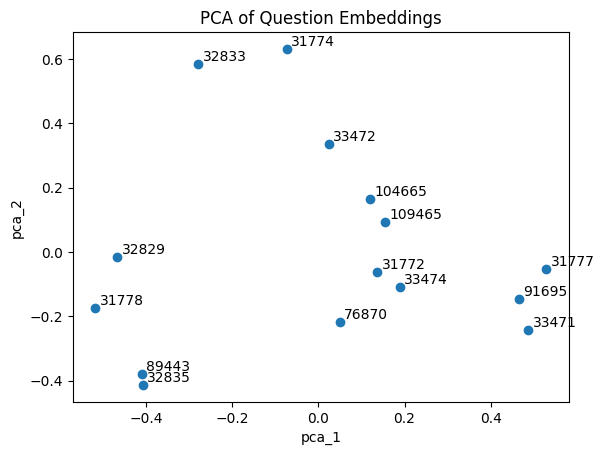

In [58]:
plt.scatter(df_pca['pca_1'], df_pca['pca_2'])

for i, txt in enumerate(df_pca['QuestionId']):
	plt.text(df_pca['pca_1'][i]+0.01, df_pca['pca_2'][i]+0.01, str(txt))

plt.xlabel('pca_1')
plt.ylabel('pca_2')
plt.title("PCA of Question Embeddings")

In [72]:
print("Comparing questions that are far apart")
print("Question 31774 vs. 32835")
print("31774: " + train[train['QuestionId'] == 31774].reset_index()['QuestionText'][0])
print("32835: " + train[train['QuestionId'] == 32835].reset_index()['QuestionText'][0])
print()
print("Question 31777 vs. 32835")
print("31777: " + train[train['QuestionId'] == 31777].reset_index()['QuestionText'][0])
print("32835: " + train[train['QuestionId'] == 32835].reset_index()['QuestionText'][0])

Comparing questions that are far apart
Question 31774 vs. 32835
31774: Calculate \( \frac{1}{2} \div 6 \)
32835: Which number is the greatest?

Question 31777 vs. 32835
31777: A box contains \( 120 \) counters. The counters are red or blue. \( \frac{3}{5} \) of the counters are red.
How many red counters are there?
32835: Which number is the greatest?


In [74]:
print("Comparing questions that are close together")
print("Question 89443 vs. 32835")
print("89443: " + train[train['QuestionId'] == 89443].reset_index()['QuestionText'][0])
print("32835: " + train[train['QuestionId'] == 32835].reset_index()['QuestionText'][0])
print()
print("Question 31777 vs. 91695 vs. 33471")
print("31777: " + train[train['QuestionId'] == 31777].reset_index()['QuestionText'][0])
print("91695: " + train[train['QuestionId'] == 91695].reset_index()['QuestionText'][0])
print("33471: " + train[train['QuestionId'] == 33471].reset_index()['QuestionText'][0])

Comparing questions that are close together
Question 89443 vs. 32835
89443: What number belongs in the box?
\(
(-8)-(-5)=
\square\)
32835: Which number is the greatest?

Question 31777 vs. 91695 vs. 33471
31777: A box contains \( 120 \) counters. The counters are red or blue. \( \frac{3}{5} \) of the counters are red.
How many red counters are there?
91695: Dots have been arranged in these patterns: [Image: Pattern 1 consists of 6 dots, Pattern 2 consists of 10 dots, Pattern 3 consists of 14 dots and Pattern 4 consists of 18 dots] How many dots would there be in Pattern \( 6 \) ?
33471: A bag contains \( 24 \) yellow and green balls. \( \frac{3}{8} \) of the balls are yellow. How many of the balls are green?


We can see some similarities and differences between each of the question types

📜 NOTE:  that the variance explained is very small, so we expect this to be quite inaccurate

In [ ]:
# For each set of questions and responses
exp = train['StudentExplanation']
embeddings = []
for e in exp:
	embeddings.append(model([e]).numpy().flatten())

embeddings = pd.DataFrame(embeddings, columns=[f"dim_{i}" for i in range(len(embeddings[0]))])
embeddings['QuestionId'] = train['QuestionId']

In [ ]:
pca_transforms = []

for qn in embeddings['QuestionId'].unique():
	d = embeddings[embeddings['QuestionId'] == qn]
	d = d.drop('QuestionId', axis=1)

	pca = PCA(n_components=2)
	an_pca = pca.fit_transform(d)
	print(f"Variance explained: {pca.explained_variance_ratio_}")

	pca_transforms.append(an_pca)

df_pca = pd.DataFrame(np.concatenate(pca_transforms), columns=['pca_1', 'pca_2'])
df_pca['QuestionId'] = train['QuestionId']
df_pca['Misconception'] = train['Misconception']
df_pca = df_pca.groupby('QuestionId').apply(lambda x: x.sample(100)).reset_index(drop=True)

Variance explained: [0.15228602 0.07808118]
Variance explained: [0.10449912 0.08289185]
Variance explained: [0.131034   0.06747535]
Variance explained: [0.09961828 0.06952132]
Variance explained: [0.10737526 0.07527745]
Variance explained: [0.10959071 0.07676546]
Variance explained: [0.07991209 0.07147408]
Variance explained: [0.11574909 0.07596719]
Variance explained: [0.1093753  0.07542372]
Variance explained: [0.10353502 0.09059097]
Variance explained: [0.12496465 0.07029963]
Variance explained: [0.10140383 0.07187554]
Variance explained: [0.10028925 0.06685563]
Variance explained: [0.11895654 0.07502297]
Variance explained: [0.11639017 0.07450189]


In [104]:
print(df_pca['QuestionId'].unique())

[ 31772  31774  31777  31778  32829  32833  32835  33471  33472  33474
  76870  89443  91695 104665 109465]


Text(0.5, 1.0, 'PCA of answers split by Misconceptions for 33471')

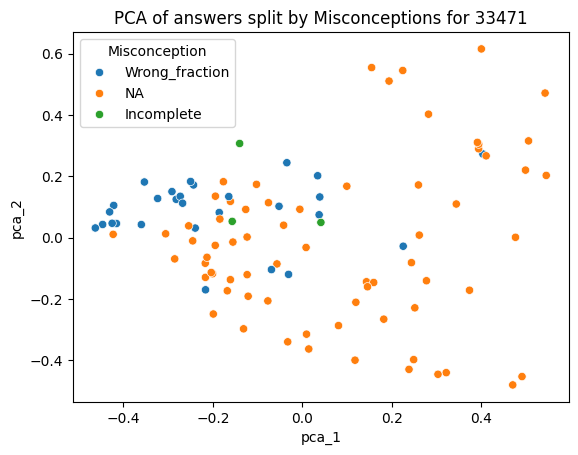

In [106]:
ID = 33471 
sns.scatterplot(
	data=p[p['QuestionId'] == ID],
	x='pca_1',
	y='pca_2',
	hue='Misconception',
	# style='Misconception'
)
plt.title(f"PCA of answers split by Misconceptions for {ID}")

[TOC](#content)

# Modeling Ideas

1. Run each text-based field on a different encoding scheme and test individually for each task which returns the best performance. Then select the best from each and combine them.
2. JSON the QuestionId for normalisation scheme

In [2]:
%watermark

Last updated: 2025-07-24T12:49:37.395088+08:00

Python implementation: CPython
Python version       : 3.11.9
IPython version      : 8.31.0

Compiler    : MSC v.1938 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 183 Stepping 1, GenuineIntel
CPU cores   : 20
Architecture: 64bit

